# Overfit y Underfit

En este proyecto vamos a aprender como trabajar el sobreajuste utilizando varias técnicas de regularización comunes para usarlas en un modelo de clasificación.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

Para este proyecto utilizaremos el conjunto de datos Higgs, un conjunto de datos comúnmente utilizado en el campo de la física de partículas y el aprendizaje automático. Pero para este proyecto no nos vamos a centrar en la física de partículas, sino en la cantidad de datos que contiene este mismo. Contiene 11.000.000 ejemplos, cada uno con 28 funciones y una etiqueta de clase binaria.

In [2]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [3]:
FEATURES = 28

In [4]:
"""

La clase tf.data.experimental.CsvDataset se puede usar para leer registros csv directamente desde un
archivo gzip sin un paso de descomprensión intermedio.

"""

ds = tf.data.experimental.CsvDataset(gz,[float(),] * (FEATURES + 1), compression_type = "GZIP")

"""

Esa clase de lector csv devuelve una lista de escalares para cada registro. La siguiente función
vuelve a empaquetar usa lista de escalares en un par(feature_vector, label).

"""

def pack_row(* row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [5]:
"""

Tensorflow es más eficiente cuando opera con grandes lotes de datos.

Entonces, en lugar de volver a empaquetar cada fila individualmente, vamos a crear un nuevo conjunto
de datos que tome lotes de 10.000 ejemplos, aplique la función pack_row a cada lote y luego divida
los lostes en registros individuales.

"""

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


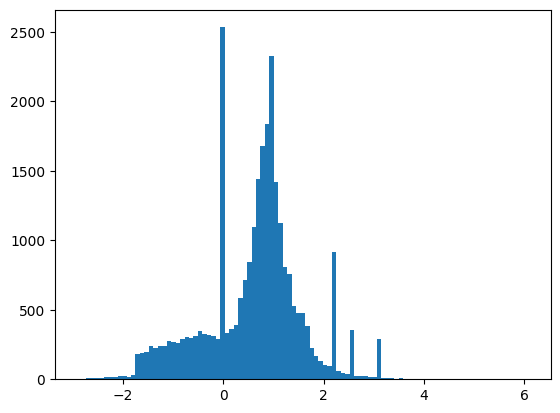

In [6]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

Como vemos, las características no están perfectamente normalizadas.

In [7]:
"""

Usaremos solo las primeras 1000 muestras para validación y las siguientes 10.000 para entrenamiento:

"""

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [8]:
"""

Los métodos Dataset.skip y Dataset.take facilitan esta tarea.

También usaremos el método Dataset.cache para asegurarnos de que el cargador no necesite volver a leer
los datos del archivo en cada época.

"""

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [9]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Estos conjuntos de datos devuelven ejemplos individuales. Usamos el método .batch para crear lotes de un tamaño adecuado para el entrenamiento. Antes de agrupar usamos .shuffle y .repeat en el conjunto de entrenamiento.

In [10]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

La forma más sencilla de evitar el sobreajuste es comenzar con un modelo pequeño: un modelo con una pequeña cantidad de parámetros que se pueden aprender (determinado por la cantidad de capas y la cantidad de unidades por capa). En el aprendizaje profundo, la cantidad de parámetros que se pueden aprender en un modelo a menudo se denomina "capacidad" del modelo.

Intuitivamente, un modelo con más parámetros tendrá más "capacidad de memorización" y, por lo tanto, podrá aprender fácilmente un mapeo perfecto tipo diccionario entre las muestras de entrenamiento y sus objetivos, un mapeo sin ningún poder de generalización, pero esto sería inútil al hacer predicciones. en datos nunca antes vistos.

Siempre tenga esto en cuenta: los modelos de aprendizaje profundo tienden a adaptarse bien a los datos de entrenamiento, pero el verdadero desafío es la generalización, no la adaptación.

Por otro lado, si la red tiene recursos de memorización limitados, no podrá aprender el mapeo tan fácilmente. Para minimizar su pérdida, tendrá que aprender representaciones comprimidas que tengan más poder predictivo. Al mismo tiempo, si hace que su modelo sea demasiado pequeño, tendrá dificultades para adaptarse a los datos de entrenamiento. Existe un equilibrio entre "demasiada capacidad" y "insuficiente capacidad".

Desafortunadamente, no existe una fórmula mágica para determinar el tamaño o la arquitectura correctos de su modelo (en términos de la cantidad de capas o el tamaño correcto para cada capa). Tendrás que experimentar usando una serie de arquitecturas diferentes.

Para encontrar un tamaño de modelo apropiado, es mejor comenzar con relativamente pocas capas y parámetros, luego comenzar a aumentar el tamaño de las capas o agregar nuevas capas hasta que vea rendimientos decrecientes en la pérdida de validación.

In [11]:
"""

Muchos modelos entrenan mejor si reduce gradualmente la tasa de aprendizaje durante el entrenamiento.
Usamos optimizers.schedules para reducir la tasa de aprendizaje con el tiempo.

"""

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH * 1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

"""

Establecimos schedules.InverseTimeDecay para disminuir hiperbólicamente la tasa de aprendizaje a la
mitad de la tasa base en 1000 épocas, 1/3 en 2000 épocas y así sucesivamente.

"""

'\n\nEstablecimos schedules.InverseTimeDecay para disminuir hiperbólicamente la tasa de aprendizaje a la\nmitad de la tasa base en 1000 épocas, 1/3 en 2000 épocas y así sucesivamente.\n\n'

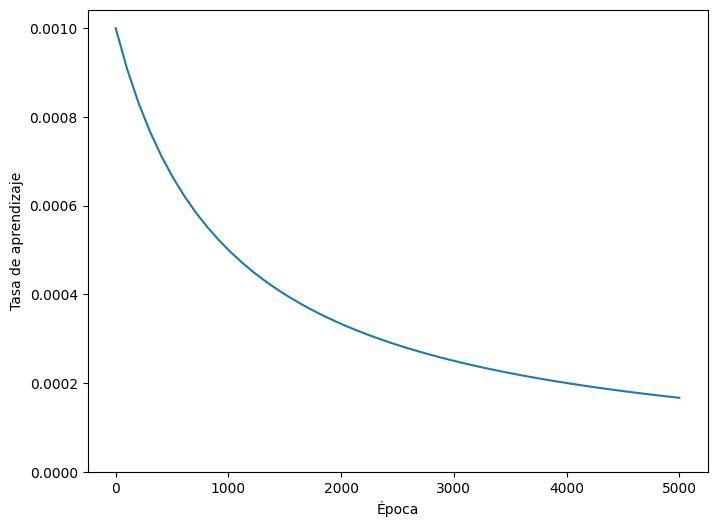

In [12]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize = (8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Época')
_ = plt.ylabel('Tasa de aprendizaje')

El entrenamiento se ejecuta durante muchas épocas cortas. Para reducir el ruido de registro, usamos 
tfdocs.EpochDots que simplemente imprime un archivo . para cada época y un conjunto completo de métricas cada 100 épocas.

Incluimos las callsbacks.EarlyStopping de llamada. EarlyStopping para evitar tiempos de entrenamientos largos e innecesarios. La devolución de la llamada está configurada para monitorear val_binary_crossentropy, no val_loss.

Usamos callbacks.TensorBoard para generar registros de TensorBoard para el entrenamiento.

In [13]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', patience = 200),
        tf.keras.callbacks.TensorBoard(logdir / name)
    ]

"""

De manera similar, cada modelo utilizará la misma configuración de Model.compile y Model.fit

"""

def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = [
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits = True,
                        name = 'binary_crossentropy'),
                    'accuracy'])
    
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0)
    
    return history

### Creamos un modelo diminuto.

In [14]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [15]:
size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4822,  binary_crossentropy:0.8285,  loss:0.8285,  val_accuracy:0.5060,  val_binary_crossentropy:0.7517,  val_loss:0.7517,  
....................................................................................................
Epoch: 100, accuracy:0.6025,  binary_crossentropy:0.6236,  loss:0.6236,  val_accuracy:0.5950,  val_binary_crossentropy:0.6221,  val_loss:0.6221,  
....................................................................................................
Epoch: 200, accuracy:0.6272,  binary_crossentropy:0.6111,  loss:0.6111,  val_accuracy:0.6140,  val_binary_crossentropy:0.6103,  val_loss:0.6103,  
....................................................................................................
Epoch: 300, accuracy:0.6457,  binary_crossentropy:0.6014,  loss:0.6014,  val_accuracy:0.6130,  val_binary_crossentropy:0.6005,  val_loss:0.6005,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

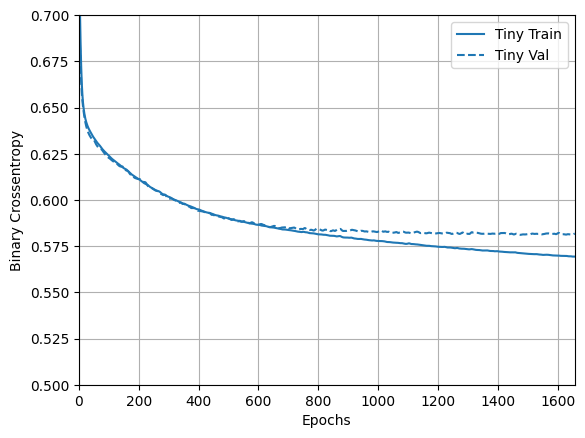

In [16]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Creamos un modelo pequeño.

Para ver si podemos superar el rendimiento del modelo pequeño, entrenamos progresivamente algunos modelos más grandes.

In [17]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(16, activation = 'elu'),
    layers.Dense(1)
])

In [18]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4821,  binary_crossentropy:0.8260,  loss:0.8260,  val_accuracy:0.4790,  val_binary_crossentropy:0.7501,  val_loss:0.7501,  
....................................................................................................
Epoch: 100, accuracy:0.6170,  binary_crossentropy:0.6176,  loss:0.6176,  val_accuracy:0.5900,  val_binary_crossentropy:0.6210,  val_loss:0.6210,  
....................................................................................................
Epoch: 200, accuracy:0.6591,  binary_crossentropy:0.5906,  loss:0.5906,  val_accuracy:0.6540,  val_binary_crossentropy:0.5952,  val_loss:0.5952,  
....................................................................................................
Epoch: 300, accuracy:0.6760,  binary_crossentropy:0.5777,  loss:0.5777,  val_accuracy:0.6690,  val_binary_crossentropy:0.5844,  val_loss:0.5844,  
....................................................................................................
Epoch: 40

### Creamos un modelo mediano.

In [19]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(64, activation = 'elu'),
    layers.Dense(64, activation = 'elu'),
    layers.Dense(1)
])

In [20]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4915,  binary_crossentropy:0.6936,  loss:0.6936,  val_accuracy:0.5170,  val_binary_crossentropy:0.6740,  val_loss:0.6740,  
....................................................................................................
Epoch: 100, accuracy:0.7042,  binary_crossentropy:0.5445,  loss:0.5445,  val_accuracy:0.6590,  val_binary_crossentropy:0.6048,  val_loss:0.6048,  
....................................................................................................
Epoch: 200, accuracy:0.7705,  binary_crossentropy:0.4488,  loss:0.4488,  val_accuracy:0.6350,  val_binary_crossentropy:0.6729,  val_loss:0.6729,  
...............................................................

### Modelo grande.

In [21]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(512, activation = 'elu'),
    layers.Dense(512, activation = 'elu'),
    layers.Dense(512, activation = 'elu'),
    layers.Dense(1)
])

In [22]:
size_histories['Large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5126,  binary_crossentropy:0.8231,  loss:0.8231,  val_accuracy:0.4690,  val_binary_crossentropy:0.6914,  val_loss:0.6914,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6570,  val_binary_crossentropy:1.7945,  val_loss:1.7945,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6600,  val_binary_crossentropy:2.4481,  val_loss:2.4481,  
..........................

### Trazar las pérdidas de entrenamiento y validación.

Las líneas continuas muestran la pérdida de entrenamiento y las líneas discontinuas muestran la pérdida de validación (recuerde: una pérdida de validación más baja indica un mejor modelo).

Si bien la construcción de un modelo más grande le da más potencia, si esta potencia no está restringida de alguna manera, puede sobreajustarse fácilmente al conjunto de entrenamiento.

En este ejemplo, normalmente, solo el modelo "Tiny" logra evitar el sobreajuste por completo, y cada uno de los modelos más grandes sobreajusta los datos más rápidamente. Esto se vuelve tan grave para el modelo "large" que necesita cambiar la gráfica a una escala logarítmica para ver realmente lo que está sucediendo.

Esto es evidente si traza y compara las métricas de validación con las métricas de entrenamiento.

* Es normal que haya una pequeña diferencia.  
* Si ambas métricas se mueven en la misma dirección, todo está bien.  
* Si la métrica de validación comienza a estancarse mientras la métrica de entrenamiento continúa mejorando, probablemente esté cerca de sobreajustarse.  
* Si la métrica de validación va en la dirección equivocada, el modelo claramente se está sobreajustando.  

Text(0.5, 0, 'Épocas [Log Scale]')

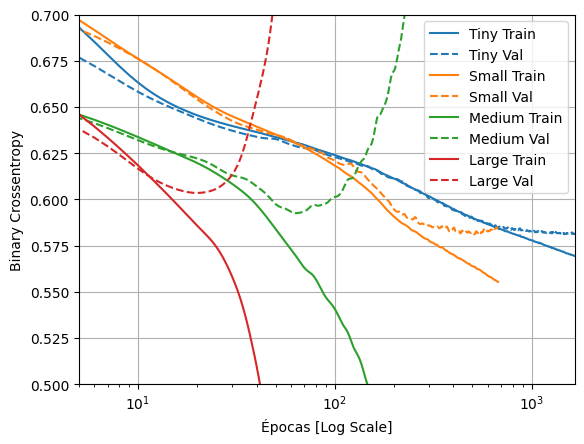

In [23]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Épocas [Log Scale]')

### Estrategias para evitar el sobreajuste.

Antes de avanzar con las estrategias, vamos a copiar los registros de entrenamiento del modelo diminuto "Tiny" para usarlos como referencia para la comparación.

In [24]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors = True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/rodri/AppData/Local/Temp/tmpi66bjfa6/tensorboard_logs/regularizers/Tiny')

In [25]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Agregamos regularización de peso.

El principio de la navaja de Occam: dadas dos explicaciones para algo, la explicación más probable que sea correcta es la "más simple", la que hace la menor cantidad de suposiciones. Esto también se aplica a los modelos aprendidos por las redes neuronales: dados algunos datos de entrenamiento y una arquitectura de red, existen múltiples conjuntos de valores de peso (múltiples modelos) que podrían explicar los datos, y es menos probable que los modelos más simples se sobreajusten que los complejos.

Un "modelo simple" en este contexto es un modelo en el que la distribución de los valores de los parámetros tiene menos entropía (o un modelo con menos parámetros en total, como vimos en la sección anterior). Por lo tanto, una forma común de mitigar el sobreajuste es imponer restricciones a la complejidad de una red forzando sus pesos solo a tomar valores pequeños, lo que hace que la distribución de los valores de peso sea más "regular". Esto se denomina "regularización de pesos", y se realiza agregando a la función de pérdida de la red un costo asociado a tener pesos elevados. Este costo viene en dos sabores:

Regularización L1 , donde el costo agregado es proporcional al valor absoluto de los coeficientes de los pesos (es decir, a lo que se llama la "norma L1" de los pesos).

Regularización L2 , donde el costo agregado es proporcional al cuadrado del valor de los coeficientes de los pesos (es decir, a lo que se llama la "norma L2" al cuadrado de los pesos). La regularización de L2 también se denomina disminución de peso en el contexto de las redes neuronales. No deje que el nombre diferente lo confunda: la disminución del peso es matemáticamente lo mismo que la regularización L2.

La regularización L1 empuja los pesos hacia exactamente cero fomentando un modelo disperso. La regularización de L2 penalizará los parámetros de peso sin hacerlos escasos, ya que la penalización llega a cero para pesos pequeños, una de las razones por las que L2 es más común.

En tf.keras , la regularización de peso se agrega pasando instancias de regularizador de peso a capas como argumentos de palabras clave. Agreguemos la regularización del peso L2.

In [26]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001),
                 input_shape = (FEATURES,)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                 kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 


 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5051,  binary_crossentropy:0.8699,  loss:2.3988,  val_accuracy:0.4830,  val_binary_crossentropy:0.6902,  val_loss:2.1541,  
....................................................................................................
Epoch: 100, accuracy:0.6522,  binary_crossentropy:0.5970,  loss:0.6209,  val_accuracy:0.6660,  val_binary_crossentropy:0.5759,  val_loss:0.6001,  
........................................................................

l2(0.001) significa que cada coeficiente en la matriz de peso de la capa agregará 0.001 * weight_coefficient_value**2 a la pérdida total de la red.

Es por eso que estamos monitoreando el binary_crossentropy directamente. Porque no tiene este componente de regularización mezclado.

(0.5, 0.7)

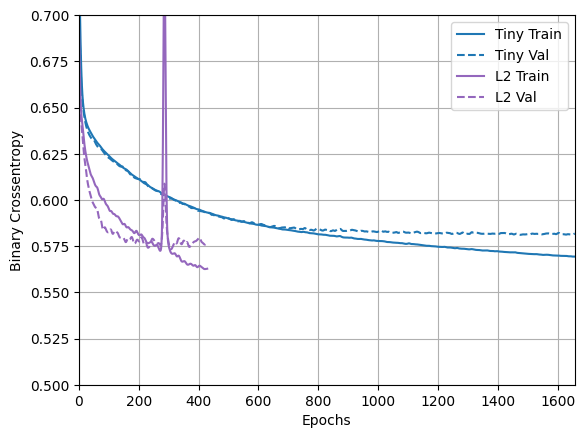

In [27]:
"""

El mismo modelo grande "Large" con una penalización de regularización l2 funciona mucho mejor.

"""

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Como se puede ver, el modelo regularizado "L2" ahora es mucho más competitivo que el modelo "Tiny" . Este modelo "L2" también es mucho más resistente al sobreajuste que el modelo "Large" en el que se basó a pesar de tener la misma cantidad de parámetros.

Hay dos cosas importantes a tener en cuenta sobre este tipo de regularización.

Primero: si está escribiendo su propio ciclo de entrenamiento, hay que asegurarse de preguntarle al modelo por sus pérdidas de regularización.

In [28]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

Segundo: esta implementación funciona agregando las penalizaciones de peso a la pérdida del modelo y luego aplicando un procedimiento de optimización estándar después de eso.

Hay un segundo enfoque que, en cambio, solo ejecuta el optimizador en la pérdida bruta, y luego, mientras aplica el paso calculado, el optimizador también aplica una disminución de peso. Esta "decadencia de peso desacoplada" se ve en optimizers.FTRL como Optimizers.FTRL y optimizers.AdamW .

### Agregar Dropout.

Dropout es una de las técnicas de regularización más efectivas y más utilizadas para redes neuronales.

La explicación intuitiva para el abandono es que debido a que los nodos individuales en la red no pueden depender de la salida de los demás, cada nodo debe generar funciones que sean útiles por sí mismas.

La eliminación, aplicada a una capa, consiste en "eliminar" aleatoriamente (es decir, poner a cero) una serie de características de salida de la capa durante el entrenamiento. Digamos que una capa dada normalmente habría devuelto un vector [0.2, 0.5, 1.3, 0.8, 1.1] para una muestra de entrada dada durante el entrenamiento; después de aplicar el abandono, este vector tendrá algunas entradas cero distribuidas al azar, por ejemplo, [0, 0.5, 1.3, 0, 1.1].

La "tasa de abandono" es la fracción de las funciones que se eliminan a cero; normalmente se establece entre 0,2 y 0,5. En el momento de la prueba, no se elimina ninguna unidad y, en cambio, los valores de salida de la capa se reducen en un factor igual a la tasa de abandono, para equilibrar el hecho de que hay más unidades activas que en el momento del entrenamiento.

En tf.keras , puede introducir el abandono en una red a través de la capa de abandono, que se aplica a la salida de la capa justo antes.

In [30]:
dropout_model = tf.keras.Sequential([
    layers.Dense('512', activation = 'elu', input_shape = (FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense('512', activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense('512', activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense('512', activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

(0.5, 0.7)

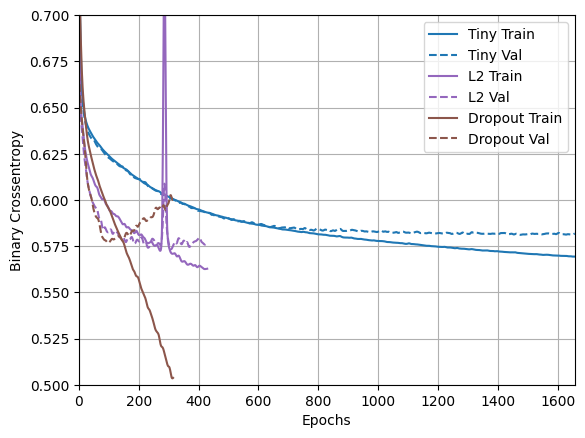

In [31]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Está claro a partir de este diagrama que ambos enfoques de regularización mejoran el comportamiento del modelo "Large". Pero esto todavía no supera ni siquiera la línea de base "Tiny".

Combinando L2 + Dropout

In [32]:
"""

Probemos ambos y veamos si funciona mejor.

"""

combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu', input_shape = (FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer = regularizers.l2(0.0001),
                 activation = 'elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 512)               14848     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)              

(0.5, 0.7)

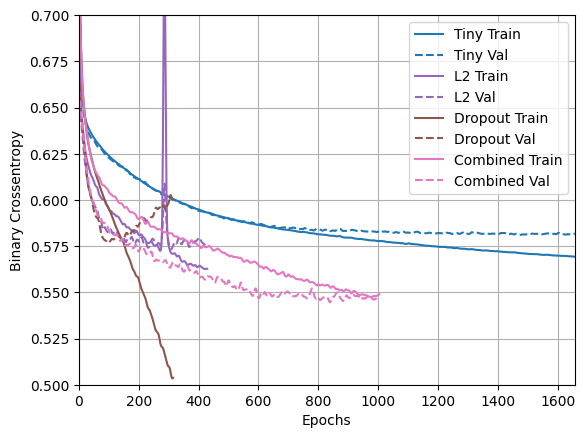

In [33]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

El modelo con la regularización "Combined" es obviamente el mejor hasta ahora.

### Conclusiones

En resumen: estas son las formas más comunes de evitar el sobreajuste en las redes neuronales:

* Obtén más datos de entrenamiento.  
* Reducir la capacidad de la red.  
* Añadir regularización de peso.  
* Añadir Dropout.  

Dos enfoques importantes que no se ven en este proyecto:  

* Aumento de datos  
* Normalización por lotes  

Es importante reocrdar que cada método puede ayudar por sí solo, pero a menudo combinarlos puede ser aún más efectivo.